# Compare 2 models
Test the original model ELECTS and the new personal model that I developed. 

For a fair comparison, we compare the trained models on the same dataset. The dataset is the same as the one used to train the ELECTS model.


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from datetime import datetime
sys.path.append("..")
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from models.earlyrnn import EarlyRNN
from models.daily_earlyrnn import DailyEarlyRNN
import torch
from utils.losses.early_reward_loss import EarlyRewardLoss
from utils.losses.stopping_time_proximity_loss import StoppingTimeProximityLoss, sample_three_uniform_numbers
from utils.losses.daily_reward_loss import DailyRewardLoss
import pandas as pd
import pickle 
import wandb
import json
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times, plot_timestamps_left_per_class
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_training import parse_args
from utils.helpers_config import set_up_config
from utils.helpers_testing import test_dataset, get_test_stats, get_test_stats_from_model
import matplotlib.pyplot as plt
from utils.plots_test import plot_doy_prob, plot_all_doy_probs, plot_confusion_matrix, plot_probability_stopping, \
    plot_fig_class_prob_wrt_time, plot_fig_class_prob_wrt_time_one_sample, plot_fig_class_prob_wrt_time_with_mus
from models.model_helpers import count_parameters
from utils.extract_mu import extract_mu_thresh
from utils.test.load_model import get_all_runs, get_best_run, download_model, get_loaded_model_and_criterion, \
    get_model_and_model_path
import argparse

In [4]:
local_dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
print("Local dataroot: ", local_dataroot)

Local dataroot:  C:\Users\anyam\elects_data


## Download the model from wandb 

In [5]:
entity, project, sweep = "aurenore", "MasterThesis", "piecewise_lin_regr"
runs_df, runs = get_all_runs(entity, project)
df = runs_df[runs_df.sweep == sweep]

In [6]:
print(f"Number of runs in sweep {sweep}: ", len(df))
df.head()

Number of runs in sweep piecewise_lin_regr:  104


,summary,config,name,sweep,start_date
19,{'boxplot': {'path': 'media/images/boxplot_100...,"{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",chocolate-sweep-104,piecewise_lin_regr,2024-06-11T12:38:32
20,"{'_step': 100, 'epoch': 100, 'alphas': [0.6000...","{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",lively-sweep-103,piecewise_lin_regr,2024-06-11T12:34:54
21,"{'kappa': 0.5338355862704276, 'recall': 0.6350...","{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",fanciful-sweep-102,piecewise_lin_regr,2024-06-11T12:32:27
22,"{'recall': 0.6408007386415818, '_runtime': 441...","{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",breezy-sweep-101,piecewise_lin_regr,2024-06-11T12:27:42
29,"{'accuracy': 0.6753106348947766, 'earliness_re...","{'mu': 150, 'loss': 'daily_reward_lin_regr', '...",gentle-sweep-100,piecewise_lin_regr,2024-06-11T11:39:45


get the best run according to a metric 

In [7]:
metric = "harmonic_mean"
run = get_best_run(df, runs, metric)
print("configurations of the best run:")
print("-"*50)
for key, value in run.config.items():
    print(f"{key}: {value}")
print("-"*50)

chosen run:  earthy-sweep-92
with harmonic_mean:  0.6680139471090303
configurations of the best run:
--------------------------------------------------
mu: 150
loss: daily_reward_lin_regr
alpha: 1
device: cuda
epochs: 100
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /home/amauron/elects/data/elects_data
p_thresh: 0.7
patience: 30
snapshot: /home/amauron/elects/data/elects_snapshots/model.pth
batchsize: 256
corrected: True
alpha_decay: [1, 0.6]
hidden_dims: 64
loss_weight: balanced
left_padding: False
weight_decay: 0
backbonemodel: LSTM
class_weights: [0.04731182754039765, 0.02670983411371708, 0.14316703379154205, 0.01290007308125496, 1, 0.011567785404622557, 0.010797104798257353]
decision_head: day
learning_rate: 0.001
nb_parameters: 66978
sequencelength: 365
validation_set: valid
daily_timestamps: True
day_head_init_bias: 5
extra_padding_list: [0]
original_time_serie_lengths: [102]
percentage_earliness_reward: 0.6
start_decision_head_training: 2
---------------------------

from the config, train the model on our own and load it here now 

In [8]:
run_name = "smart-water-4628"
run_pers_model_on_og_dataset_idx = runs_df[runs_df.name == run_name].index[0]
run_pers_model_on_og_dataset = runs[run_pers_model_on_og_dataset_idx]
run_pers_config = argparse.Namespace(**run_pers_model_on_og_dataset.config)

### load the og ELECTS model
It was already trained and saved in the wandb.

In [26]:
run_name_og_elects = "ELECTS-LSTM"
run_og_elects_idx = runs_df[runs_df.name == run_name_og_elects].index[0]
run_og_elects = runs[run_og_elects_idx]
model_og_elects, model_path_og_elects = get_model_and_model_path(run_og_elects)
run_og_elects_config = argparse.Namespace(**run_og_elects.config)
print("config:\n")
for key, value in run_og_elects.config.items():
    print(f"{key}: {value}")

wandb:   1 of 1 files downloaded.  


config:

alpha: 0.5
device: cuda
epochs: 100
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /mydata/studentanya/anya/elects_data
patience: 30
snapshot: /mydata/studentanya/anya/elects_snapshots/breizhcrops/elects-breizhcrops-training/model.pth
batchsize: 256
criterion: EarlyRewardLoss
optimizer: AdamW
architecture: EarlyRNN
weight_decay: 0
learning_rate: 0.001
sequencelength: 70


## Test the two models on the test set 

In [17]:
args, _ = set_up_config(run_og_elects_config)
print(args)
args.dataroot = local_dataroot

Namespace(alpha=0.5, device='cuda', epochs=100, resume=False, dataset='breizhcrops', epsilon=10, dataroot='C:\\Users\\anyam\\elects_data', patience=30, snapshot='/mydata/studentanya/anya/elects_snapshots/breizhcrops/elects-breizhcrops-training/model.pth', batchsize=256, criterion='EarlyRewardLoss', optimizer='AdamW', architecture='EarlyRNN', weight_decay=0, learning_rate=0.001, sequencelength=70, backbonemodel='LSTM', hidden_dims=64, decision_head='', loss='early_reward', validation_set='valid', left_padding=False, extra_padding_list=[0], daily_timestamps=False, alpha_decay=[0.5, 0.5], corrected=False, original_time_serie_lengths=None)


## Test.py - Test the model on the validation set 

In [54]:
# ----------------------------- LOAD DATASET -----------------------------
sequencelength_test = 150 # by elects paper
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    test_ds = BreizhCrops(root=dataroot, partition="eval", sequencelength=sequencelength_test, corrected=args.corrected, \
        daily_timestamps=args.daily_timestamps, original_time_serie_lengths=args.original_time_serie_lengths, return_id=True)
    nclasses = test_ds.nclasses
    class_names = test_ds.labels_names
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:44<00:00, 2764.49it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


In [55]:
# print all the attributes of test_ds
print("Attributes of test_ds:")
for attr in dir(test_ds):
    if not attr.startswith("__"):
        print(attr, ":", getattr(test_ds, attr))

Attributes of test_ds:
_is_protocol : False
class_weights : None
corrected : False
daily_timestamps : False
ds : <data.breizhcrops.BzhBreizhCrops object at 0x0000020D90F09950>
get_class_weights : <bound method BreizhCrops.get_class_weights of <data.breizhcrops.BreizhCrops object at 0x0000020D94F0AD90>>
get_sequence_lengths : <bound method BreizhCrops.get_sequence_lengths of <data.breizhcrops.BreizhCrops object at 0x0000020D94F0AD90>>
labels_names : ['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']
nclasses : 9
return_id : True
sequencelength : 150


Extracting labels from dataset Test.


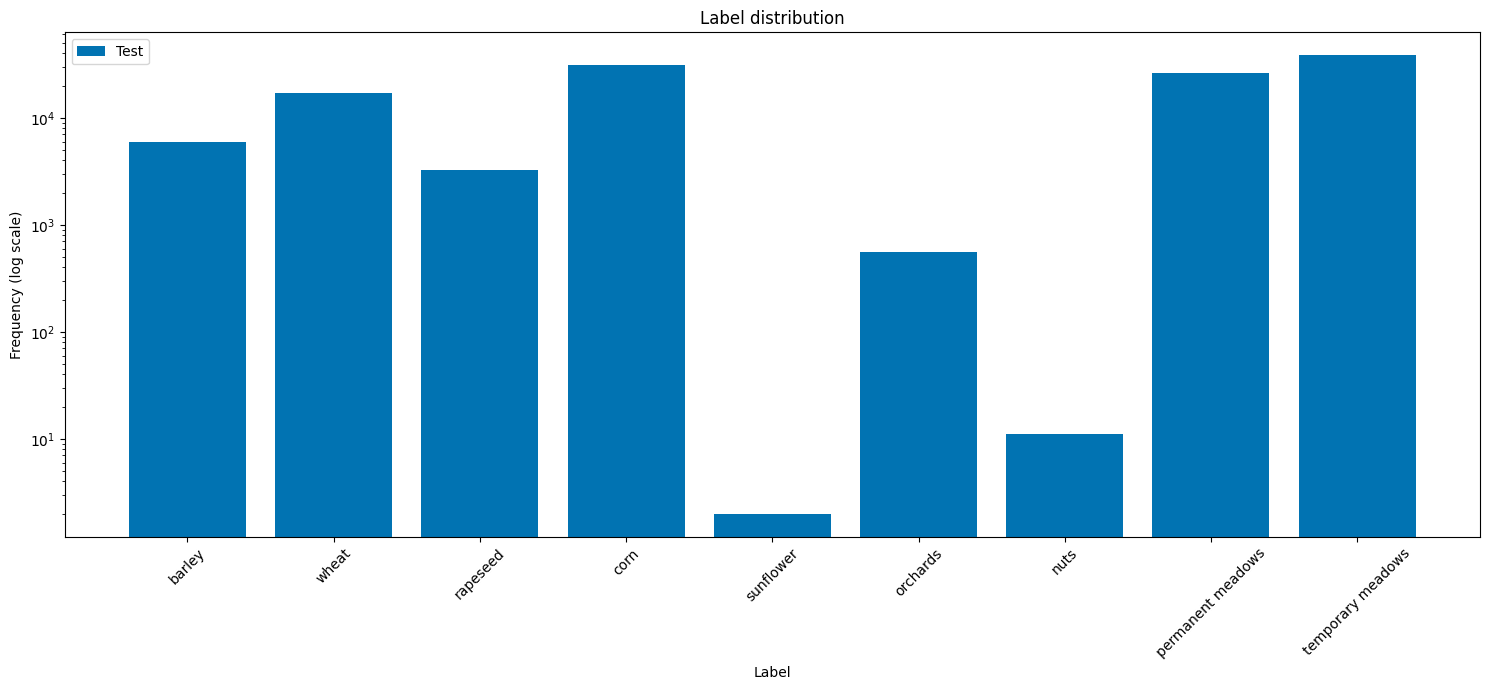

In [56]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Test"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

## Load the models and the criterions

In [57]:
model_og_elects, criterion_og_elects = get_loaded_model_and_criterion(run_og_elects, nclasses, input_dim)
print("."*50)
model_pers, criterion_pers = get_loaded_model_and_criterion(run_pers_model_on_og_dataset, nclasses, input_dim)


wandb:   1 of 1 files downloaded.  


model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-z6s1065x-model.pth-v8
The model has 67,108 trainable parameters.
..................................................


wandb:   1 of 1 files downloaded.  


loss daily_reward_lin_regr selected, setting mus to 28
model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-dovekjsx-model.pth-v6
The model has 67,108 trainable parameters.


## Test the model on the test dataset

In [58]:
true_og_elects_model_path = r"C:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\ELECTS-LSTM"
with open(os.path.join(true_og_elects_model_path, "stats.pkl"), "rb") as f:
    true_stats_og_elects = pickle.load(f)
with open(os.path.join(true_og_elects_model_path, "testloss.pkl"), "rb") as f:
        true_testloss_og_elects = pickle.load(f)
true_test_stats_og_elects = get_test_stats(true_stats_og_elects, true_testloss_og_elects, args)
# print("true stats og elects: ", true_stats_og_elects)
print("true test stats og elects: ")
for key, value in true_test_stats_og_elects.items():
    print(f"{key}: {value}")

true test stats og elects: 
test_loss: 0.9596295952796936
accuracy: 0.8007242239874729
precision: 0.6780434612408308
recall: 0.5700856358132275
fscore: 0.5698957997690282
kappa: 0.7403988633095924
elects_earliness: 0.6799818116615759
classification_loss: 5.975773334503174
earliness_reward: 4.056514739990234
harmonic_mean: 0.7354301196316072


In [59]:
# compare the config from true_og_elects_model_path with the one from the run
# load the json file "config.json" from the true_og_elects_model_path
true_og_elects_config = json.load(open(os.path.join(true_og_elects_model_path, "config.json")))
print("config from true_og_elects_model_path:")
for key, value in true_og_elects_config.items():
    print(f"{key}: {value}")
print("-"*50)
print("config from run:")
for key, value in run_og_elects.config.items():
    print(f"{key}: {value}")
print("-"*50)
# spot the differences
for key, value in true_og_elects_config.items():
    if value != run_og_elects.config[key]:
        print(f"{key}: {value} != {run_og_elects.config[key]}")

config from true_og_elects_model_path:
alpha: 0.5
device: cuda
epochs: 100
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /mydata/studentanya/anya/elects_data
patience: 30
snapshot: /mydata/studentanya/anya/elects_snapshots/breizhcrops/elects-breizhcrops-training/model.pth
batchsize: 256
criterion: EarlyRewardLoss
optimizer: AdamW
architecture: EarlyRNN
weight_decay: 0
learning_rate: 0.001
sequencelength: 70
--------------------------------------------------
config from run:
alpha: 0.5
device: cuda
epochs: 100
resume: False
dataset: breizhcrops
epsilon: 10
dataroot: /mydata/studentanya/anya/elects_data
patience: 30
snapshot: /mydata/studentanya/anya/elects_snapshots/breizhcrops/elects-breizhcrops-training/model.pth
batchsize: 256
criterion: EarlyRewardLoss
optimizer: AdamW
architecture: EarlyRNN
weight_decay: 0
learning_rate: 0.001
sequencelength: 70
--------------------------------------------------


In [60]:
test_stats_og_elects, stats_og_elects = get_test_stats_from_model(model_og_elects, test_ds, criterion_og_elects, run_og_elects_config)
test_stats_og_elects

{'test_loss': 0.9596296,
 'accuracy': 0.8005529548012462,
 'precision': 0.6779266012220249,
 'recall': 0.5696778310154632,
 'fscore': 0.5690429697401728,
 'kappa': 0.7401747171419808,
 'elects_earliness': 0.6800162073366567,
 'classification_loss': 5.9757733,
 'earliness_reward': 4.0565147,
 'harmonic_mean': 0.7353779857335594}

In [61]:
# compare stats_og_elects with true_stats_og_elects
print("stats_og_elects:")
for key, value in stats_og_elects.items():
    print(f"{key}: {value[0]}")
    print(f"true_{key}: {true_stats_og_elects[key][0]}")
    print("-"*100)

stats_og_elects:
classification_loss: [7.052409]
true_classification_loss: [7.052409]
----------------------------------------------------------------------------------------------------
earliness_reward: [3.7678995]
true_earliness_reward: [3.7678995]
----------------------------------------------------------------------------------------------------
probability_making_decision: [0.06666698 0.06666671 0.06666668 0.06666793 0.06668412 0.06667995
 0.06667349 0.06667171 0.06666847 0.06666771 0.06666733 0.06666698
 0.06666762 0.06666881 0.06667017 0.06667053 0.06668188 0.06667974
 0.0667099  0.06685822 0.06681963 0.06739252 0.06743284 0.06750678
 0.0683919  0.06848397 0.07141218 0.08730417 0.1176282  0.09657006
 0.12111455 0.10147341 0.09032638 0.2459094  0.4246713  0.2513015
 0.10958572 0.07390458 0.06845164 0.06731483 0.06668282 0.0666668
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.066

In [23]:
test_stats_pers, stats_pers = get_test_stats_from_model(model_pers, test_ds, criterion_pers, run_pers_config)
test_stats_pers

{'test_loss': 0.022516662,
 'accuracy': 0.3556526987130344,
 'precision': 0.44211855732329025,
 'recall': 0.4469332702874545,
 'fscore': 0.3594536967125286,
 'kappa': 0.28972360076457737,
 'elects_earliness': 0.0,
 'classification_loss': 0.022516662,
 'earliness_reward': 0.0,
 'harmonic_mean': 0.0}

## Graphs

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-z6s1065x-model.pth-v8\boxplot_stopping_times.png


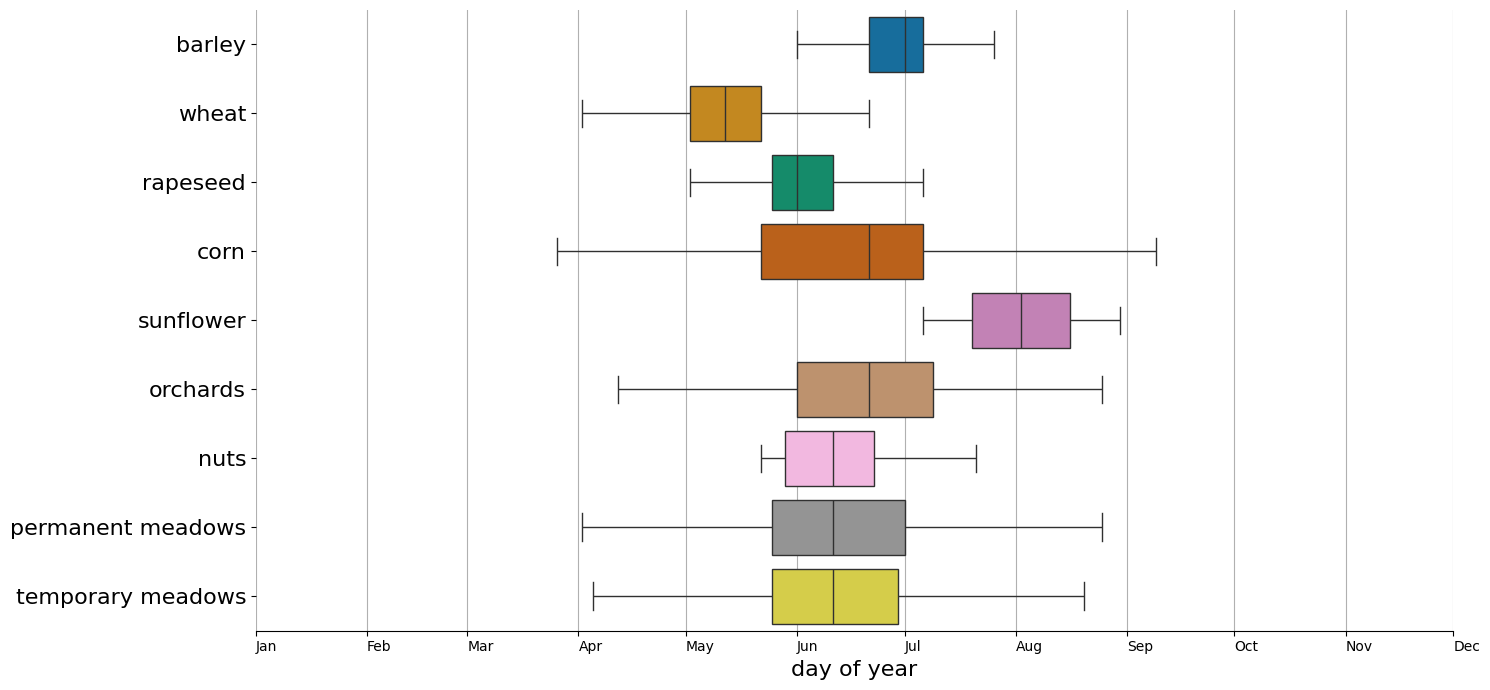

In [63]:
from utils.doy import get_doys_dict_test, get_doy_stop, create_sorted_doys_dict_test, get_approximated_doys_dict, get_approximated_doy

stats = stats_og_elects
model_path = model_path_og_elects
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
if args.daily_timestamps:
    doys_stop = stats["t_stop"].squeeze()
else: 
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    doys_stop = get_doy_stop(stats, doys_dict_test, approximated=False)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)
                
fig_boxplot.savefig(os.path.join(model_path, "boxplot_stopping_times.png"))
print("fig saved at ", os.path.join(model_path, "boxplot_stopping_times.png"))

fig saved at  c:\Users\anyam\Desktop\Master_thesis\Code\elects\results_analysis_notebooks\artifacts\run-z6s1065x-model.pth-v8\confusion_matrix.png


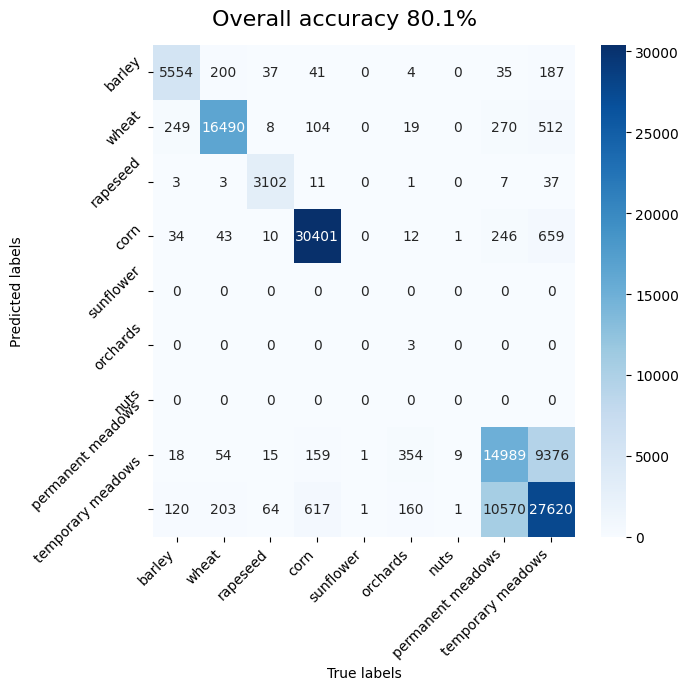

In [64]:
fig, ax = plt.subplots(figsize=(7,7))
fig = plot_confusion_matrix(stats["targets"][:, 0], stats["predictions_at_t_stop"].flatten(), class_names, fig, ax)
fig.savefig(os.path.join(model_path, "confusion_matrix.png"))
print("fig saved at ", os.path.join(model_path, "confusion_matrix.png"))